# Imports

In [345]:
#!pip install -U scikit-learn

In [346]:
from Transformation import Transformation
import numpy as np
from sklearn.neighbors import NearestNeighbors
import networkx as nx

# Input

In [347]:
transformation = Transformation()

# Create objects
stl_file_path = "3d_models/stl/Handle.stl"
mesh_data = transformation.stl_to_mesh(stl_file_path)
graph = transformation.mesh_to_graph(mesh_data)

transformation.print_graph_properties(graph, display_graph=False, display_labels=False)

Number of nodes: 5999
Number of edges: 17991


In [348]:
print(graph._node)

{(75.0252, -0.66553295, 3.8): {'index_triangle': {0, 6820, 164, 165, 6821, 6822}}, (75.01418, -0.49935842, 16.7): {'index_triangle': {0, 1, 165, 370, 371, 372}}, (75.0, 0.0, 3.8): {'index_triangle': {0, 1, 2, 6658, 6659, 11415, 11416, 11417, 6822, 6823, 6824, 6825, 6826, 6827, 6828, 6829, 6830, 6831, 6832, 6833, 6834, 6835, 6836, 6837, 6838, 6839, 6840, 6841, 6842, 6843, 6844, 6845, 6846, 6847, 6848, 6849, 6850, 6851, 6852, 6853, 6854, 6855, 6856, 6857, 6858, 6859, 6860, 6861, 6862, 6863, 6864, 6865, 6866, 6867, 6868, 6869, 6870, 6871, 6872, 6873, 6874, 6875, 6876, 6877, 6878, 6495}}, (75.00158, 0.16653232, 16.7): {'index_triangle': {1, 2, 3, 372, 373, 374}}, (75.0252, 0.66553295, 3.8): {'index_triangle': {2, 6659, 3, 4, 6660}}, (75.03937, 0.8314692, 16.7): {'index_triangle': {3, 4, 5, 374, 375, 376}}, (75.10067, 1.3272538, 3.8): {'index_triangle': {6660, 6661, 4, 5, 6, 6662}}, (75.12734, 1.4916434, 16.7): {'index_triangle': {5, 6, 7, 376, 377, 378}}, (75.22596, 1.9813722, 3.8): {'inde

# Point Sampler

### DevConv

In [349]:
def relu(array):
    return np.maximum(array, 0)

def sigmoid(array):
    return 1 / (1 + np.exp(-array))

In [350]:
class DevConv():
    def __init__(self, graph, output_dimension):
        self.graph = graph
        self.list_node = list(graph._node)

        self.W_phi = np.random.random((output_dimension))      #change
        self.W_theta = np.array([0.2, 0.2, 0.2])  # change
    
    def forward(self, previous_inclusion_score, return_flatten=True):
        list_inc_score = np.zeros((len(self.list_node), len(self.W_phi)))
        for index_current_node, (current_node, dict_neigh) in enumerate(self.graph._adj.items()):
            # print(index_current_node, " | ", current_node, " | ", dict_neigh)
            neigh_distances = np.zeros(shape=len(dict_neigh))
            for index_neigh, neigh_node in enumerate(dict_neigh.keys()):
                neigh_distances[index_neigh] = np.linalg.norm(np.multiply(self.W_theta, np.array(current_node) - np.array(neigh_node))) # norm(W_theta * (xi - xj))
            list_inc_score[index_current_node] = self.W_phi * np.max(neigh_distances)                                   # W_phi * max(distance)    

        # return if no previous inclusion score
        if len(previous_inclusion_score)==0:
            if return_flatten:
                list_inc_score = list_inc_score.flatten()
            return list_inc_score
        
        # mean the rows if more than one column
        if list_inc_score.shape[1]!=1:
            list_inc_score = np.mean(list_inc_score, axis=1)

        # array of array to array
        if len(list_inc_score.shape)==2:
            if list_inc_score.shape[1]==1:
                list_inc_score = list_inc_score.flatten()

        # Return the mean of previous and current inclusion score
        return np.mean(np.array([previous_inclusion_score, list_inc_score], dtype=np.float64), axis=0)
        

In [351]:
devconv = DevConv(graph, 1)
inclusion_score = devconv.forward(previous_inclusion_score=np.array([]))
inclusion_score = relu(inclusion_score)
print(inclusion_score)

devconv = DevConv(graph, 64)
inclusion_score = devconv.forward(previous_inclusion_score=inclusion_score)
inclusion_score = relu(inclusion_score)
print(inclusion_score)

devconv = DevConv(graph, 1)
inclusion_score = devconv.forward(previous_inclusion_score=inclusion_score)
inclusion_score = sigmoid(inclusion_score)
print(inclusion_score)
print(inclusion_score.shape)

[0.19570875 0.19582262 0.19570875 ... 0.18219826 0.26447562 0.18219826]
[0.74046086 0.74089167 0.74046086 ... 0.68934412 1.00063917 0.68934412]
[0.73358638 0.73370154 0.73358638 ... 0.71969948 0.79718618 0.71969948]
(5999,)


### Multinomial Sampling

In [352]:
normalized_inclusion_score = inclusion_score / np.sum(inclusion_score)  # normalize for multinomial sampling
normalized_inclusion_score = np.round(normalized_inclusion_score, 8)    # round to remove float imprecision

number_throws = 500     # small:more randomness    |   big:less randomness
mult_sampling = np.random.multinomial(number_throws, normalized_inclusion_score)
print(mult_sampling)

[0 0 0 ... 0 0 0]


In [353]:
target_number_point = min(len(graph._node), 48)   # number of points for the simplification

index_k_nodes = np.argpartition(mult_sampling, -target_number_point)[-target_number_point:]
list_k_nodes = np.array(list(graph._node.keys()))[index_k_nodes]
list_k_nodes = [tuple(e) for e in list_k_nodes]
print(list_k_nodes)

[(75.918144, 0.99710757, 98.719284), (75.91289, -1.6554987, 98.61897), (87.9346, 7.5075808, 84.66582), (81.04593, -8.610001, 0.30938062), (90.81851, 5.2797017, 2.9709868), (88.262985, 7.138877, 85.50941), (80.400604, -8.722893, -1.6006067), (75.00527, 1.3272538, 3.699471), (80.18807, -8.610001, -0.87136054), (84.519646, 7.8332825, 89.77153), (75.0, 8.114116, 93.406044), (75.0, 7.5075808, 94.59089), (85.928276, 8.535009, 3.2272732), (75.0, 7.138877, 95.14552), (75.79835, -8.722893, -3.7957716), (75.36537, 8.610001, 88.17167), (75.78312, -6.2811418, 96.142876), (83.85614, -8.798424, 2.3973253), (75.0, -8.348472, 92.78263), (88.926414, -7.138877, 3.0701475), (88.372536, -7.5075808, 3.0991752), (75.0, 7.328478, -0.12830497), (78.60937, 7.138877, 94.67034), (75.0, -8.722893, 88.83761), (87.53002, 7.8332825, 83.863335), (76.31718, -8.447791, -2.396843), (75.15066, 6.5098743, 0.9252234), (83.28927, -8.78582, 3.365578), (83.99175, -8.760632, 0.34839013), (75.22565, -1.9813722, 3.7881742), (77.

# KNN

In [354]:
XYZ = [list(e) for e in list_k_nodes]
print(XYZ)

[[75.918144, 0.99710757, 98.719284], [75.91289, -1.6554987, 98.61897], [87.9346, 7.5075808, 84.66582], [81.04593, -8.610001, 0.30938062], [90.81851, 5.2797017, 2.9709868], [88.262985, 7.138877, 85.50941], [80.400604, -8.722893, -1.6006067], [75.00527, 1.3272538, 3.699471], [80.18807, -8.610001, -0.87136054], [84.519646, 7.8332825, 89.77153], [75.0, 8.114116, 93.406044], [75.0, 7.5075808, 94.59089], [85.928276, 8.535009, 3.2272732], [75.0, 7.138877, 95.14552], [75.79835, -8.722893, -3.7957716], [75.36537, 8.610001, 88.17167], [75.78312, -6.2811418, 96.142876], [83.85614, -8.798424, 2.3973253], [75.0, -8.348472, 92.78263], [88.926414, -7.138877, 3.0701475], [88.372536, -7.5075808, 3.0991752], [75.0, 7.328478, -0.12830497], [78.60937, 7.138877, 94.67034], [75.0, -8.722893, 88.83761], [87.53002, 7.8332825, 83.863335], [76.31718, -8.447791, -2.396843], [75.15066, 6.5098743, 0.9252234], [83.28927, -8.78582, 3.365578], [83.99175, -8.760632, 0.34839013], [75.22565, -1.9813722, 3.7881742], [77.

In [355]:
def connect_extended_graph(XYZ, number_neigh=15):
    # Create the nearest neighbors object
    _, indices = NearestNeighbors(n_neighbors=number_neigh).fit(XYZ).kneighbors(XYZ)
    # Create the graph from the nearest points
    extended_graph = nx.Graph()
    for index_poly, poly in enumerate(indices):
        for index_current_node in range(len(poly)):
            current_node = tuple(XYZ[poly[index_current_node]])
            for index_other_node in range(index_current_node+1, len(poly)):
                edge = current_node, tuple(XYZ[poly[index_other_node]])
                extended_graph.add_edge(*edge)
                # if attribute do not exists
                if len(extended_graph.nodes[current_node])==0:
                    extended_graph.nodes[current_node]['index_poly'] = set()
                extended_graph.nodes[current_node]['index_poly'].add(index_poly)
    return extended_graph

In [356]:
extended_graph = connect_extended_graph(XYZ)

Number of nodes: 48
Number of edges: 522


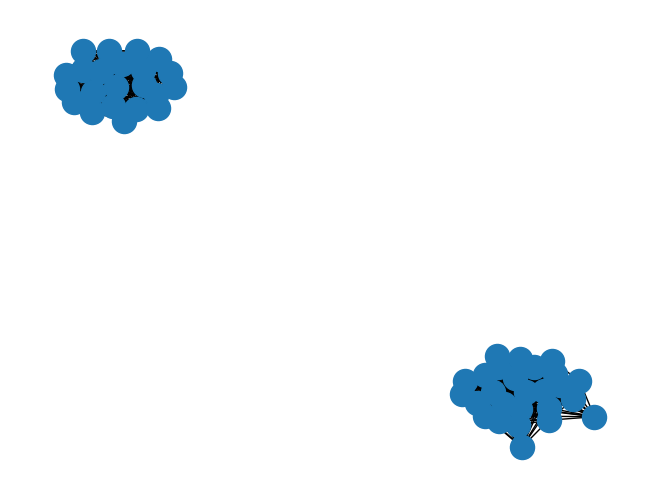

In [357]:
transformation.print_graph_properties(graph=extended_graph, display_graph=True, display_labels=False)

# Edge Predictor

In [358]:
devconv = DevConv(extended_graph, 64)
inclusion_score = devconv.forward(previous_inclusion_score=np.array([]), return_flatten=False)
print(inclusion_score.shape)

(48, 64)


In [359]:
"""
inclusion_score = [[f_1_1  , f_1_2  , ..., f_63_1  ],
                    ...,
                   [f_1_M-1, f_1_M-1, ..., f_63_M-1]]
M = number of points
64 = hidden dimensions
"""
from numpy import mean

#construction du fi
# fi = np.random.randint(100, size=(50, 1))
# for n in range(np.size(inclusion_score,0)):
#     fi[i] = np.mean(inclusion_score[i][:])
    
# fj = np.random.randint(100, size=(50, 1))
# for m in range(np.size(inclusion_score,0)):
#     fj[i] = np.mean(inclusion_score[i][:])

f = np.random.rand(target_number_point)


# f1i = np.mean(inclusion_score)
# f1j = np.mean(inclusion_score)

S = np.random.rand(target_number_point, target_number_point)
wq = np.random.rand(64)
wk = np.random.rand(64)

In [360]:
for i in range(np.size(f,0)):
    for j in range(np.size(f, 0)): 
        f[i] = np.mean(inclusion_score[i][:])
        #print("f[",i,"] : " , f[i])
        f[j] = np.mean(inclusion_score[j][:])
        #print("f[",j,"] : " , f[j])
        wq_fi = wq*f[i].transpose()
        #print("wq_fi : " , wq_fi.transpose())
        wk_fj = wk*f[j]
        #print("wk_fj : " , wk_fj)
        wq_wk = np.matmul(wk_fj, wq_fi)
        #print("wq_wk : " , wq_wk)
        sum_wq_wk = 0
        for k in range(np.size(f, 0)):
            f[k] = np.mean(inclusion_score[k][:])
            #print("f[",k,"]",f[k])
            
            #print("wk*f[",k,"] * wq_fi = ",np.matmul(wk*f[k],wq_fi))
            #print("exp : " ,np.exp(np.matmul(wk*f[k],wq_fi))) #ça marche mais faut réduire les valeurs c'est trop grand
            sum_wq_wk += np.exp(np.matmul(wk*f[k],wq_fi))
            #print("somme : " , sum_wq_wk)
        print ("exp(wq_wk) :" , np.exp(wq_wk)) #error exp( ) vaut inf & overflow error
        print("somme : ", sum_wq_wk)
        S[i][j] = np.exp(wq_wk)/sum_wq_wk
        print("S[",i,"][",j,"] :" , S[i][j])


exp(wq_wk) : 1.389977987663351e+123
somme :  6.640380504185371e+150
S[ 0 ][ 0 ] : 2.093220391191831e-28
exp(wq_wk) : 2.0602486490501485e+121
somme :  6.640380504185371e+150
S[ 0 ][ 1 ] : 3.102606315634462e-30
exp(wq_wk) : 1.2754930971914286e+124
somme :  6.640380504185371e+150
S[ 0 ][ 2 ] : 1.92081326723295e-27
exp(wq_wk) : 2.105370529095536e+117
somme :  6.640380504185371e+150
S[ 0 ][ 3 ] : 3.1705570603499906e-34
exp(wq_wk) : 1.8457728935831136e+124
somme :  6.640380504185371e+150
S[ 0 ][ 4 ] : 2.7796191685397245e-27
exp(wq_wk) : 1.1915803307468176e+134
somme :  6.640380504185371e+150
S[ 0 ][ 5 ] : 1.7944458604379303e-17
exp(wq_wk) : 3.0750536998225676e+124
somme :  6.640380504185371e+150
S[ 0 ][ 6 ] : 4.6308396000566374e-27
exp(wq_wk) : 7.833184962819144e+112
somme :  6.640380504185371e+150
S[ 0 ][ 7 ] : 1.1796289320893523e-38
exp(wq_wk) : 1.0945535940088153e+125
somme :  6.640380504185371e+150
S[ 0 ][ 8 ] : 1.6483296300850957e-26
exp(wq_wk) : 8.830455101160768e+111
somme :  6.640380

### Sparse Attention

# Face Candidates

#### Inputs

In [361]:
adjacency = nx.adjacency_matrix(extended_graph)
S = np.random.rand(target_number_point, target_number_point)
print(adjacency)
print(S)

  (0, 1)	1
  (0, 2)	1
  (0, 3)	1
  (0, 4)	1
  (0, 5)	1
  (0, 6)	1
  (0, 7)	1
  (0, 8)	1
  (0, 9)	1
  (0, 10)	1
  (0, 11)	1
  (0, 12)	1
  (0, 13)	1
  (0, 14)	1
  (0, 15)	1
  (0, 16)	1
  (0, 17)	1
  (0, 18)	1
  (0, 19)	1
  (0, 47)	1
  (1, 0)	1
  (1, 2)	1
  (1, 3)	1
  (1, 4)	1
  (1, 5)	1
  :	:
  (46, 33)	1
  (46, 34)	1
  (46, 35)	1
  (46, 36)	1
  (46, 37)	1
  (46, 38)	1
  (46, 39)	1
  (46, 40)	1
  (46, 41)	1
  (46, 42)	1
  (46, 44)	1
  (47, 0)	1
  (47, 1)	1
  (47, 2)	1
  (47, 3)	1
  (47, 4)	1
  (47, 5)	1
  (47, 6)	1
  (47, 7)	1
  (47, 8)	1
  (47, 9)	1
  (47, 10)	1
  (47, 12)	1
  (47, 13)	1
  (47, 15)	1
[[0.84181361 0.79827492 0.72279173 ... 0.38748557 0.73589537 0.16477184]
 [0.27551247 0.28899819 0.80933925 ... 0.03548715 0.73913806 0.66711074]
 [0.72031249 0.31936463 0.585563   ... 0.99164283 0.67352999 0.55954789]
 ...
 [0.67542425 0.93808846 0.89997192 ... 0.46068118 0.99998261 0.85644879]
 [0.96659032 0.83490514 0.94704882 ... 0.87395675 0.38499605 0.27522196]
 [0.79659746 0.913885  

In [362]:
A_s = np.zeros((target_number_point,target_number_point))

for i in range(target_number_point):
    for j in range(target_number_point):
        A_s[i,j] = np.matmul(np.matmul(S[i,:], adjacency.A), S[j,:][np.newaxis].T)

print(A_s)  # symmétrique
print(A_s.shape)

[[205.69507552 243.09110353 230.28476264 ... 262.01051552 250.26606637
  245.2224215 ]
 [243.09110353 284.29664665 273.93607005 ... 307.91266581 296.43567399
  283.44672455]
 [230.28476264 273.93607005 260.80365524 ... 294.01481155 283.34105587
  268.61541892]
 ...
 [262.01051552 307.91266581 294.01481155 ... 327.48337373 317.31273034
  304.6772208 ]
 [250.26606637 296.43567399 283.34105587 ... 317.31273034 301.26942019
  292.48218407]
 [245.2224215  283.44672455 268.61541892 ... 304.6772208  292.48218407
  286.62701405]]
(48, 48)


c:\Users\Arthur\miniconda3\envs\meshPFE\lib\site-packages\scipy\sparse\_base.py:719: VisibleDeprecationWarning: `.A` is deprecated and will be removed in v1.13.0. Use `.toarray()` instead.
  warn(np.VisibleDeprecationWarning(


# Face Classifier

### TriConv

#### Inputs

In [363]:
triangles = list(nx.simple_cycles(extended_graph, length_bound=3))  # [triangle0, triangle1,...] | triangle0 = [node1,node2,node3] | node1 = (x ,y ,z)
print(triangles)
print(np.array(triangles).shape)    #nb_triangle, 3 nodes, 3 dimensions par node

[[(81.04593, -8.610001, 0.30938062), (82.130325, -8.722893, 1.062925), (80.18807, -8.610001, -0.87136054)], [(81.04593, -8.610001, 0.30938062), (82.130325, -8.722893, 1.062925), (80.400604, -8.722893, -1.6006067)], [(81.04593, -8.610001, 0.30938062), (82.130325, -8.722893, 1.062925), (83.99175, -8.760632, 0.34839013)], [(81.04593, -8.610001, 0.30938062), (82.130325, -8.722893, 1.062925), (83.85614, -8.798424, 2.3973253)], [(81.04593, -8.610001, 0.30938062), (82.130325, -8.722893, 1.062925), (83.28927, -8.78582, 3.365578)], [(81.04593, -8.610001, 0.30938062), (82.130325, -8.722893, 1.062925), (76.57269, -7.9794145, -1.0402565)], [(81.04593, -8.610001, 0.30938062), (82.130325, -8.722893, 1.062925), (76.31718, -8.447791, -2.396843)], [(81.04593, -8.610001, 0.30938062), (82.130325, -8.722893, 1.062925), (75.79835, -8.722893, -3.7957716)], [(81.04593, -8.610001, 0.30938062), (82.130325, -8.722893, 1.062925), (77.492805, -8.760632, -5.503285)], [(81.04593, -8.610001, 0.30938062), (82.130325,

In [364]:
p_init = np.zeros((len(triangles)))

for index_triangle, triangle in enumerate(triangles):
    i = list(dict(extended_graph._node).keys()).index(triangle[0])
    j = list(dict(extended_graph._node).keys()).index(triangle[1])
    k = list(dict(extended_graph._node).keys()).index(triangle[2])
    p_init[index_triangle] = (A_s[i,j] + A_s[i,k] + A_s[j,k])/3
print(p_init)

[282.41219501 323.88795944 307.00701158 ... 269.7148335  283.26670062
 275.45964594]


#### Calculate barycenter

In [365]:
barycenters = list()

for _, triangle in enumerate(triangles):
    b_x = (triangle[0][0] + triangle[1][0] + triangle[2][0]) / 3
    b_y = (triangle[0][1] + triangle[1][1] + triangle[2][1]) / 3
    b_z = (triangle[0][2] + triangle[1][2] + triangle[2][2]) / 3
    barycenters.append([b_x, b_y, b_z])

print(barycenters)
print(len(barycenters))

[[81.12143961588542, -8.647631327311197, 0.16698169708251953], [81.19228617350261, -8.685262044270834, -0.07610034942626953], [82.3893330891927, -8.69784164428711, 0.5735652446746826], [82.34413146972656, -8.710439046223959, 1.2565436363220215], [82.15517171223958, -8.70623779296875, 1.5792945226033528], [79.91631571451823, -8.437435785929361, 0.11068304379781087], [79.83114624023438, -8.593561808268229, -0.34151244163513184], [79.658203125, -8.685262044270834, -0.8078219890594482], [80.2230224609375, -8.69784164428711, -1.376993179321289], [83.70361836751302, -8.280157725016275, 0.5688298543294271], [83.84959920247395, -8.280157725016275, 1.490493615468343], [79.56005859375, -6.861591339111328, 1.6020619074503581], [84.03422037760417, -8.157257080078125, 1.4808177947998047], [84.66492207845052, -4.017730712890625, 1.4477640787760417], [83.81307983398438, -3.398005485534668, 0.2876336971918742], [83.0348409016927, -2.9326279958089194, 1.5331929524739583], [79.44230143229167, -3.6076730

In [366]:
def connect_triangle_graph(XYZ, number_neigh=20):
    # Create the nearest neighbors object
    _, indices = NearestNeighbors(n_neighbors=number_neigh).fit(XYZ).kneighbors(XYZ)
    # Create the graph from the nearest points
    extended_graph = nx.Graph()
    for index_poly, poly in enumerate(indices):
        for index_current_node in range(len(poly)):
            current_node = tuple(XYZ[poly[index_current_node]])
            for index_other_node in range(index_current_node+1, len(poly)):
                edge = current_node, tuple(XYZ[poly[index_other_node]])
                extended_graph.add_edge(*edge)
                # if attribute do not exists
                if len(extended_graph.nodes[current_node])==0:
                    extended_graph.nodes[current_node]['index_poly'] = set()
                extended_graph.nodes[current_node]['index_poly'].add(index_poly)
    return extended_graph

In [367]:
graph_triangles = connect_triangle_graph(barycenters)
print(graph_triangles._node)

{(81.12143961588542, -8.647631327311197, 0.16698169708251953): {'index_poly': {0, 1, 261, 1572, 1573, 1318, 1319, 1320, 1574, 46, 304, 305, 1334, 1335, 322, 323, 340, 342, 488, 489}}, (81.2926534016927, -8.70623779296875, 0.2978702386220296): {'index_poly': {0, 1, 23, 24, 25, 1572, 1573, 1318, 1319, 1320, 1574, 45, 46, 304, 1333, 1334, 1335, 322, 323, 488, 489}}, (81.02645874023438, -8.756448109944662, -0.027267853418986004): {'index_poly': {0, 1, 323, 324, 261, 325, 1319, 488, 489, 1320, 1573, 1574, 304, 305, 342, 1334, 1335}}, (81.19228617350261, -8.685262044270834, -0.07610034942626953): {'index_poly': {0, 1, 323, 324, 261, 325, 1319, 488, 489, 1320, 1573, 1574, 1575, 304, 305, 342, 23, 1335}}, (81.3883565266927, -8.668949127197266, 0.11629080772399902): {'index_poly': {0, 1, 23, 24, 25, 1572, 1573, 1318, 1319, 1320, 1574, 44, 45, 46, 304, 1334, 1335, 323, 582, 342, 488, 489}}, (80.89825439453125, -8.487646102905273, 0.12368619441986084): {'index_poly': {0, 1, 261, 1688, 1689, 1573,

In [368]:
transformation.print_graph_properties(graph=graph_triangles, display_graph=False, display_labels=False)

Number of nodes: 3504
Number of edges: 105223


#### calculate e norm matrix

In [369]:
diff_vectors = list()

for _, triangle in enumerate(triangles):
    e_ij = np.linalg.norm(np.array(triangle[0]) - np.array(triangle[1]))
    e_ik = np.linalg.norm(np.array(triangle[0]) - np.array(triangle[2]))
    e_jk = np.linalg.norm(np.array(triangle[1]) - np.array(triangle[2]))
    diff_vectors.append([e_ij, e_ik, e_jk])
print(diff_vectors)
print(len(diff_vectors))

[[1.3253261, 1.4594753, 2.7434564], [1.3253261, 2.0192177, 3.1758993], [1.3253261, 2.9499304, 1.9942156], [1.3253261, 3.5060382, 2.1828344], [1.3253261, 3.7952375, 2.5786273], [1.3253261, 4.714764, 5.9886065], [1.3253261, 5.4507847, 6.770404], [1.3253261, 6.663492, 7.9812827], [1.3253261, 6.8142834, 8.038851], [1.3253261, 6.9763703, 5.974752], [1.3253261, 7.916909, 6.677461], [1.3253261, 8.3178005, 8.914182], [1.3253261, 8.478684, 7.26119], [1.3253261, 17.190443, 16.58909], [1.3253261, 17.34311, 17.078568], [1.3253261, 18.063852, 17.802921], [1.3253261, 16.2402, 16.75625], [1.3253261, 17.052269, 17.604177], [1.3253261, 12.113268, 12.598539], [1.3253261, 11.595702, 12.089866], [1.3253261, 11.27482, 12.127502], [1.3253261, 9.482426, 10.027446], [1.4594753, 2.0192177, 0.76792866], [1.4594753, 2.9499304, 3.9973075], [1.4594753, 3.5060382, 4.9167604], [1.4594753, 3.7952375, 5.253568], [1.4594753, 4.714764, 3.6738446], [1.4594753, 5.4507847, 4.163801], [1.4594753, 6.663492, 5.2758517], [1.45

#### Calculate r

In [371]:
r_matrix = np.zeros((len(triangles),len(triangles), 5))

max_diff_vectors = np.array(diff_vectors).max(axis=1)
min_diff_vectors = np.array(diff_vectors).min(axis=1)

barycenters_numpy = np.array(barycenters)

# Calculate differences once to avoid redundant computations
diff_vectors = min_diff_vectors[:, np.newaxis] - min_diff_vectors
max_diff_vectors_diff = max_diff_vectors[:, np.newaxis] - max_diff_vectors
barycenters_diff = barycenters_numpy[:, np.newaxis, :] - barycenters_numpy

# Populate the r_matrix using vectorized operations
r_matrix = np.stack([diff_vectors, max_diff_vectors_diff, barycenters_diff[:, :, 0], barycenters_diff[:, :, 1], barycenters_diff[:, :, 2]], axis=-1)

print(r_matrix.shape)   # nb_triangles, nb_triangles, 5dim/triangles

(3504, 3504, 5)


#### Calculate f

In [372]:
# MLP * 3 
f_final = p_init    # TODO

import torch
final_scores = torch.nn.functional.softmax(torch.tensor(f_final))
final_scores = final_scores.numpy()
print(final_scores.sum())
print(final_scores.shape)
print(final_scores)

0.9999999999999999
(3504,)
[1.51565457e-29 1.56061530e-11 7.27768668e-19 ... 4.63667006e-35
 3.56210982e-29 1.44926077e-32]


C:\Users\Arthur\AppData\Local\Temp\ipykernel_10060\4023725568.py:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  final_scores = torch.nn.functional.softmax(torch.tensor(f_final))


# Simplified Mesh

In [373]:
selected_triangles_indexes = np.argpartition(final_scores, -target_number_point)[-target_number_point:] 
selected_triangles = np.array(triangles)[selected_triangles_indexes]
print(selected_triangles.shape) # number triangles, number points, number dimensions(x,y,z)

(48, 3, 3)


In [374]:
def create_triangle_graph(XYZ):
    extended_graph = nx.Graph()
    for index_poly, poly in enumerate(XYZ):
        for index_current_node in range(len(poly)):
            current_node = tuple(poly[index_current_node])
            for index_other_node in range(index_current_node+1, len(poly)):
                edge = current_node, tuple(poly[index_other_node])
                extended_graph.add_edge(*edge)
                # if attribute do not exists
                if len(extended_graph.nodes[current_node])==0:
                    extended_graph.nodes[current_node]['index_triangle'] = set()
                extended_graph.nodes[current_node]['index_triangle'].add(index_poly)
                if len(extended_graph.nodes[tuple(poly[index_other_node])])==0:
                    extended_graph.nodes[tuple(poly[index_other_node])]['index_triangle'] = set()
                extended_graph.nodes[tuple(poly[index_other_node])]['index_triangle'].add(index_poly)
    return extended_graph

In [375]:
simplified_final_graph = create_triangle_graph(selected_triangles)
print(simplified_final_graph._node)

{(87.9346, 7.5075808, 84.66582): {'index_triangle': {0, 4, 5, 8, 13, 18, 19, 20, 23, 24, 25, 28, 30, 31, 36, 40, 44, 45, 46}}, (75.0, 8.114116, 93.406044): {'index_triangle': {0, 32, 33, 34, 4, 8, 12, 24}}, (81.3266, -8.447791, 81.53156): {'index_triangle': {0, 32, 35, 13, 45, 15, 20, 26, 27, 30}}, (76.57269, -7.9794145, -1.0402565): {'index_triangle': {1, 10, 21}}, (80.400604, -8.722893, -1.6006067): {'index_triangle': {1, 2, 3, 37, 6, 7, 39, 9, 10, 11, 41, 42, 16, 17, 21, 22}}, (83.99175, -8.760632, 0.34839013): {'index_triangle': {1, 2, 41, 7}}, (83.85614, -8.798424, 2.3973253): {'index_triangle': {2, 6, 39}}, (82.130325, -8.722893, 1.062925): {'index_triangle': {3, 37, 39, 9, 10, 11, 41, 16}}, (88.262985, 7.138877, -0.50940454): {'index_triangle': {3}}, (75.0, -8.722893, 88.83761): {'index_triangle': {33, 4, 5, 43, 46, 47, 23, 26, 28, 29, 30}}, (75.91289, -1.6554987, 98.61897): {'index_triangle': {5, 43, 14, 15, 25}}, (75.013725, 0.66553295, 3.7788632): {'index_triangle': {42, 37, 

In [376]:
transformation.print_graph_properties(graph=simplified_final_graph, display_graph=False, display_labels=False)

Number of nodes: 23
Number of edges: 59


In [377]:
simplified_final_mesh = transformation.graph_to_mesh(simplified_final_graph)

transformation.mesh_to_display_vtk(mesh_data)
transformation.mesh_to_display_vtk(simplified_final_mesh)